In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.api import VAR
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tcn import TCN

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [36]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n')

In [8]:
data = pd.read_csv("Microsoft Dataset.csv")

In [9]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9627,2024-05-24,427.190002,431.059998,424.410004,430.160004,430.160004,11845800
9628,2024-05-28,429.630005,430.820007,426.600006,430.320007,430.320007,15718000
9629,2024-05-29,425.690002,430.940002,425.690002,429.170013,429.170013,15517100
9630,2024-05-30,424.299988,424.299988,414.239990,414.670013,414.670013,28394500


In [10]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [11]:
# Split the data into features (X) and target variable (y)
X = data.drop(columns=['Close', 'Adj Close'])  # Excluding 'Close' and 'Adj Close' columns as features
y = data['Close']


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  

## Traditional Models


#### Linear regression

In [13]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [14]:
# Predict on the test set
y_pred = lr_model.predict(X_test)

In [15]:
y_pred, y_test


(array([ 57.30494769,  57.81025324,  57.4810412 , ..., 429.94345067,
        416.35962787, 407.18235325]),
 Date
 2016-10-04     57.240002
 2016-10-05     57.639999
 2016-10-06     57.740002
 2016-10-07     57.799999
 2016-10-10     58.040001
                  ...    
 2024-05-24    430.160004
 2024-05-28    430.320007
 2024-05-29    429.170013
 2024-05-30    414.670013
 2024-05-31    406.760010
 Name: Close, Length: 1927, dtype: float64)

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 1.8057188662580752
Mean Absolute Error (MAE): 0.8935531399643343
Root Mean Squared Error (RMSE): 1.3437703919413
Mean Absolute Percentage Error (MAPE): 0.43529552143768985


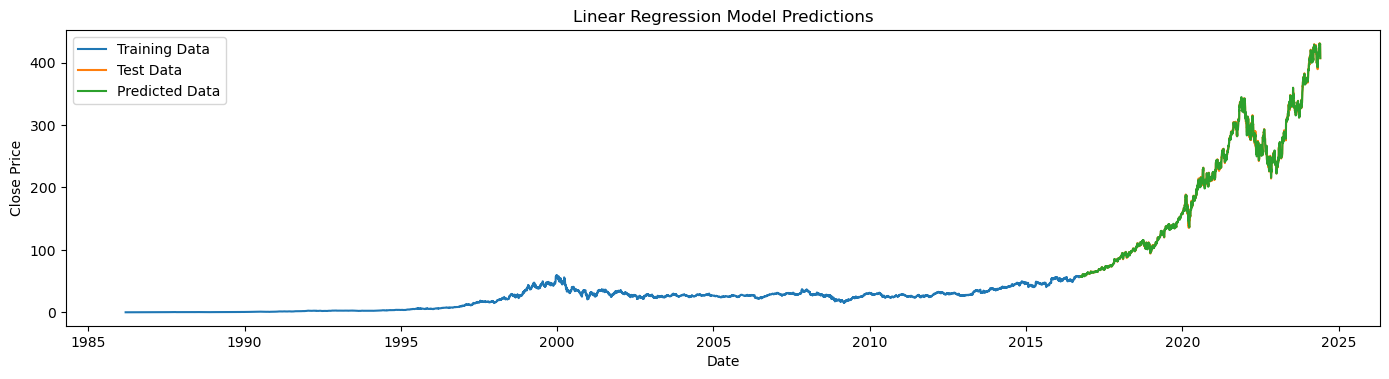

In [22]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, y_test, label='Test Data')
plt.plot(test_data.index, y_pred, label='Predicted Data')
plt.legend()
plt.title('Linear Regression Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

#### Arima

In [18]:
# Step 3: Train-test split
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

In [19]:
train_data = train_data.drop(columns = ["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)
test_data = test_data.drop(columns = ["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)

In [20]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [21]:
train_scaled

array([[1.16760393e-04],
       [1.75140589e-04],
       [2.04347502e-04],
       ...,
       [9.63638520e-01],
       [9.67001367e-01],
       [9.63974744e-01]])

In [34]:
# Use auto_arima to find the best ARIMA model
arima_model = auto_arima(train_scaled, seasonal=False, trace=True,
                         error_action='ignore', suppress_warnings=True,
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-51156.422, Time=6.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51160.823, Time=2.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51162.965, Time=2.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-51162.910, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51161.246, Time=0.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-51161.361, Time=3.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51159.383, Time=2.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-51154.821, Time=2.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-51163.313, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-51161.733, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-51159.693, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-51163.257, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-51155.243, Time=1.94 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 26.949 sec

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [35]:
forecast_period = len(test_scaled)
y_pred_arima = arima_model.predict(n_periods=forecast_period)
y_pred_arima = scaler.inverse_transform(y_pred_arima.reshape(-1, 1))

In [36]:
# Evaluate the model
mse = mean_squared_error(test_data.values, y_pred_arima)
mae = mean_absolute_error(test_data.values, y_pred_arima)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data.values, y_pred_arima)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 31340.253875343686
Mean Absolute Error (MAE): 143.58315533239312
Root Mean Squared Error (RMSE): 177.03178775390504
Mean Absolute Percentage Error (MAPE): 60.430280726549 %


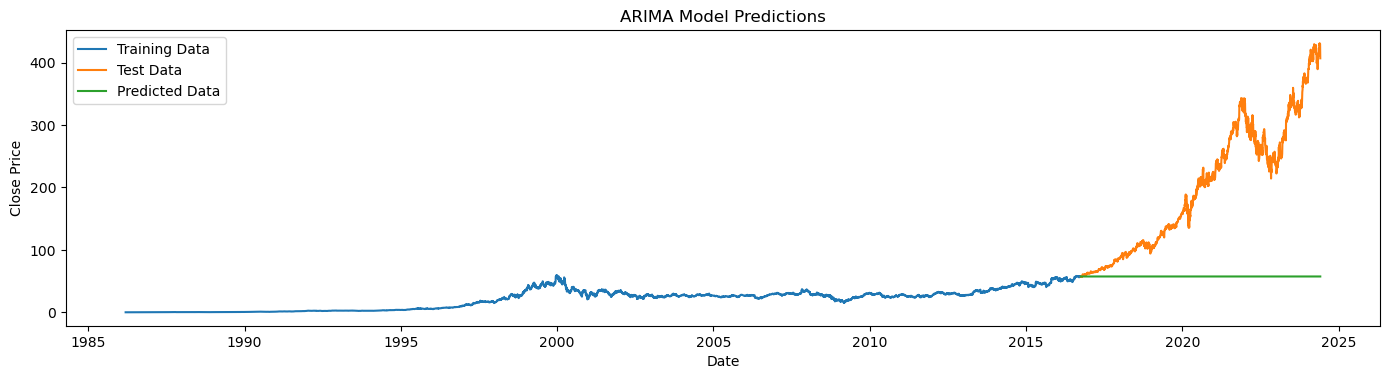

In [37]:

# Plot the results
plt.figure(figsize=(14, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, y_pred_arima, label='Predicted Data')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

#### Sarima

In [418]:
sarima_model = SARIMAX(train_scaled, order=(1,1,0), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

In [425]:
# Forecasting
n_forecast = len(test_data)
y_pred_sarima = arima_model.predict(n_periods=forecast_period)
y_pred_sarima = scaler.inverse_transform(y_pred_sarima.reshape(-1, 1))

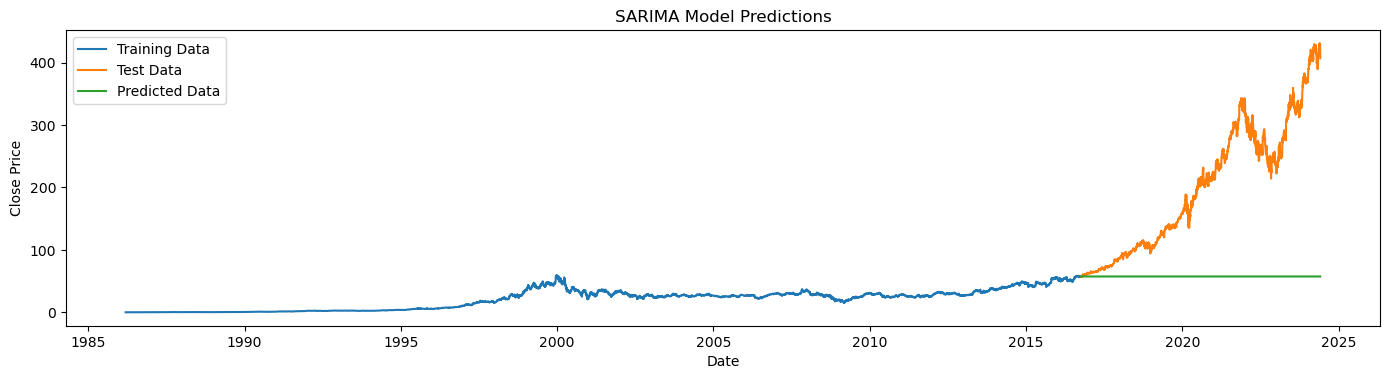

In [429]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, y_pred_sarima, label='Predicted Data')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

In [430]:
# Evaluate the model
mse = mean_squared_error(test_data.values, y_pred_sarima)
mae = mean_absolute_error(test_data.values, y_pred_sarima)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data.values, y_pred_sarima)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 31340.253875343686
Mean Absolute Error (MAE): 143.58315533239312
Root Mean Squared Error (RMSE): 177.03178775390504
Mean Absolute Percentage Error (MAPE): 60.430280726549 %


## DeepLearning Models

#### LSTM

In [23]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [24]:
features = ['Open', 'High', 'Low', 'Volume']
features_transformer = MinMaxScaler()
Close_transformer = MinMaxScaler()

features_transformer = features_transformer.fit(train[features].to_numpy())
Close_transformer = Close_transformer.fit(train[['Close']])

train.loc[:, features] = features_transformer.transform(train[features].to_numpy())
train['Close'] = Close_transformer.transform(train[['Close']])
test.loc[:, features] = features_transformer.transform(test[features].to_numpy())
test['Close'] = Close_transformer.transform(test[['Close']])

C:\Users\Tony\AppData\Local\Temp\ipykernel_30360\2390795849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = Close_transformer.transform(train[['Close']])
C:\Users\Tony\AppData\Local\Temp\ipykernel_30360\2390795849.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = Close_transformer.transform(test[['Close']])


In [25]:
time_steps = 24
# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print('X_train:', X_train.shape, 'Y_train:', y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', y_test.shape)

X_train: (7681, 24, 6) Y_train: (7681,)
X_test: (1903, 24, 6) Y_test: (1903,)


In [26]:
#Setting the return_sequences=True makes each cell per timestep emit a signal.
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.LSTM(128, activation ='relu',input_shape=X_train.shape[-2:],return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(128, activation ='relu',return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(units=128,activation ='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=1),])
model_LSTM.summary()

model_LSTM.compile(optimizer= 'adam', loss='mse')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,417 (1.27 MB)

 Trainable params: 332,417 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
es = EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

In [ ]:
lstm_history = model_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,batch_size=64, verbose=1,callbacks=es)

Epoch 1/50
121/121 [==============================] - 19s 96ms/step - loss: 0.0119 - val_loss: 54.5068
Epoch 2/50
121/121 [==============================] - 11s 90ms/step - loss: 0.0033 - val_loss: 15.1163
Epoch 3/50
121/121 [==============================] - 11s 90ms/step - loss: 0.0027 - val_loss: 0.0492
Epoch 4/50
121/121 [==============================] - 10s 86ms/step - loss: 0.0024 - val_loss: 0.8785
Epoch 5/50
121/121 [==============================] - 10s 86ms/step - loss: 0.0023 - val_loss: 0.1664
Epoch 6/50
121/121 [==============================] - 10s 86ms/step - loss: 0.0021 - val_loss: 0.5373
Epoch 7/50
121/121 [==============================] - 10s 86ms/step - loss: 0.0020 - val_loss: 2.2659
Epoch 8/50
121/121 [==============================] - 11s 87ms/step - loss: 0.0020 - val_loss: 2.7619
Epoch 9/50
121/121 [==============================] - 11s 87ms/step - loss: 0.0019 - val_loss: 5.1683
Epoch 10/50
121/121 [==============================] - 11s 87ms/step - loss: 0.0

In [582]:
y_pred_lstm = model_LSTM.predict(X_test)

61/61 [==============================] - 1s 4ms/step


In [583]:
y_train_inv = Close_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = Close_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = Close_transformer.inverse_transform(y_pred_lstm)

In [586]:
timeseries_evaluation_metrics_func(y_test , y_pred_lstm)

Evaluation metric results:-
MSE is : 11.315084036528619
MAE is : 2.7193663926328275
RMSE is : 3.3637901296794097
MAPE is : 72.96138051677369
R2 is : -2.733479808792566



In [ ]:
model_LSTM.save('LSTM_model_0.04.h5')

### GRU

In [631]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.GRU(128, activation ='relu',input_shape=X_train.shape[-2:],return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.GRU(128, activation ='relu',return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.GRU(units=128,activation ='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=1),])
model_GRU.summary()

model_GRU.compile(optimizer= 'adam', loss='mse')

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 24, 128)           52224     
                                                                 
 dropout_60 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_10 (GRU)                (None, 24, 128)           99072     
                                                                 
 dropout_61 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 128)               99072     
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 1)               

In [632]:
gru_history = model_GRU.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,batch_size=64, verbose=1,callbacks=es)

Epoch 1/50
121/121 [==============================] - 28s 177ms/step - loss: 0.0090 - val_loss: 0.2491
Epoch 2/50
121/121 [==============================] - 21s 171ms/step - loss: 0.0017 - val_loss: 0.8465
Epoch 3/50
121/121 [==============================] - 20s 166ms/step - loss: 0.0015 - val_loss: 1.3509
Epoch 4/50
121/121 [==============================] - 20s 167ms/step - loss: 0.0014 - val_loss: 1.5338
Epoch 5/50
121/121 [==============================] - 20s 168ms/step - loss: 0.0013 - val_loss: 2.1909
Epoch 6/50
121/121 [==============================] - 21s 170ms/step - loss: 0.0013 - val_loss: 1.9224
Epoch 7/50
121/121 [==============================] - 21s 170ms/step - loss: 0.0012 - val_loss: 2.0215
Epoch 8/50
121/121 [==============================] - 20s 167ms/step - loss: 0.0011 - val_loss: 2.1489
Epoch 9/50
121/121 [==============================] - 20s 167ms/step - loss: 0.0011 - val_loss: 2.1813
Epoch 10/50
121/121 [==============================] - 21s 170ms/step - l

In [633]:
y_pred_GRU = model_GRU.predict(X_test)

60/60 [==============================] - 2s 29ms/step


In [634]:
timeseries_evaluation_metrics_func(y_test,y_pred_GRU)

Evaluation metric results:-
MSE is : 0.24910926347418455
MAE is : 0.36119523610790455
RMSE is : 0.4991084686460294
MAPE is : 69.6280180674409
R2 is : 0.9168850949929765



In [636]:
model_GRU.save('GRU_model_0.24.h5')

C:\Users\Tony\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### TCN

In [29]:
def create_tcn():
    i = Input(shape=(X_train.shape[1], X_train.shape[2]))
    m = TCN(nb_filters=32,
                     kernel_size=4,
                     nb_stacks=4,
                     dilations=(2, 4, 8,16),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.2,
                     activation='relu',
                     kernel_initializer='glorot_uniform',
                     use_batch_norm=False,
                     use_layer_norm=False,
                     return_sequences = False)(i)
    
    m = Dense(1, activation='linear')(m)
    model = Model(inputs=[i], outputs=[m])
    model.summary()
    
    return model

model_tcn = create_tcn()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 24, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_2 (TCN)                          │ (None, 32)                  │         148,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,193 (578.88 KB)

 Trainable params: 148,193 (578.88 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_tcn.compile(loss='mse', optimizer='adam')
tcn_history = model_tcn.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[es],verbose=2,epochs=50,batch_size=64)


Epoch 1/50
121/121 - 22s - 178ms/step - loss: 0.0031 - val_loss: 0.3360
Epoch 2/50
121/121 - 5s - 37ms/step - loss: 0.0014 - val_loss: 0.0148
Epoch 3/50
121/121 - 4s - 36ms/step - loss: 7.5985e-04 - val_loss: 0.1698
Epoch 4/50
121/121 - 4s - 37ms/step - loss: 9.4524e-04 - val_loss: 0.0124
Epoch 5/50
121/121 - 4s - 37ms/step - loss: 6.7065e-04 - val_loss: 0.1047
Epoch 6/50
121/121 - 4s - 37ms/step - loss: 3.2152e-04 - val_loss: 0.0442
Epoch 7/50
121/121 - 5s - 37ms/step - loss: 3.1176e-04 - val_loss: 0.0626
Epoch 8/50
121/121 - 4s - 37ms/step - loss: 3.8430e-04 - val_loss: 0.0221
Epoch 9/50
121/121 - 4s - 37ms/step - loss: 3.0131e-04 - val_loss: 0.1032
Epoch 10/50
121/121 - 4s - 37ms/step - loss: 2.8366e-04 - val_loss: 0.0187
Epoch 11/50
121/121 - 4s - 37ms/step - loss: 2.7052e-04 - val_loss: 0.0212
Epoch 12/50
121/121 - 5s - 38ms/step - loss: 2.4405e-04 - val_loss: 0.0283
Epoch 13/50
121/121 - 4s - 37ms/step - loss: 5.1032e-04 - val_loss: 1.4402
Epoch 14/50
121/121 - 5s - 38ms/step - l

In [32]:
y_pred_tcn = model_tcn.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [37]:
timeseries_evaluation_metrics_func(y_test,y_pred_tcn)

Evaluation metric results:-
MSE is : 0.005375963313248998
MAE is : 0.05563854122263165
RMSE is : 0.07332096094057278
MAPE is : 79.05985663655655
R2 is : 0.9982063184890423



In [38]:
model_tcn.save('TCN_model_0.0053.h5')